In [1]:
%matplotlib inline


# Generalized Matrix LVQ (GMLVQ)

Example of how to use GMLVQ `[1]`_ on the classic diabetes dataset.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklvq import GMLVQ

matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

# Contains also the target_names and feature_names, which we will use for the plots.
wine = load_wine()

data = wine.data
labels = wine.target
feature_names = [name[:-5] for name in wine.feature_names]

## Fitting the Model
Scale the data and create a GLVQ object with, e.g., custom distance function, activation
function and solver. See the API reference under documentation for defaults and other
possible parameters.



In [3]:
# Sklearn's standardscaler to perform z-transform
scaler = StandardScaler()

# Compute (fit) and apply (transform) z-transform
data = scaler.fit_transform(data)

# The creation of the model object used to fit the data to.
model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="waypoint-gradient-descent",
    solver_params={"max_runs": 10, "k": 3, "step_size": np.array([0.1, 0.05])},
    random_state=1428,
)

The next step is to fit the GMLVQ object to the data and use the predict method to make the
predictions. Note that this example only works on the training data and therefor does not say
anything about the generalizability of the fitted model.



In [4]:
# Train the model using the scaled data and true labels
model.fit(data, labels)

# Predict the labels using the trained model
predicted_labels = model.predict(data)
print(len(data))

# To get a sense of the training performance we could print the classification report.
print(classification_report(labels, predicted_labels))

178
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00        48

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



## Extracting the Relevance Matrix
In addition to the prototypes (see GLVQ example), GMLVQ learns a
matrix `lambda_` which can tell us something about which features are most relevant for the
classification.



['al', 'malic', '', 'alcalinity_o', 'magn', 'total_ph', 'flava', 'nonflavanoid_ph', 'proanthocy', 'color_inte', '', 'od280/od315_of_diluted_', 'pr']


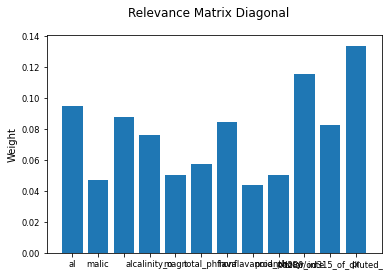

In [9]:
# The relevance matrix is available after fitting the model.
relevance_matrix = model.lambda_

# Plot the diagonal of the relevance matrix
fig, ax = plt.subplots()
fig.suptitle("Relevance Matrix Diagonal")
print(feature_names)
ax.bar(feature_names, np.diagonal(relevance_matrix))
ax.set_ylabel("Weight")
ax.grid(False)

In [6]:
relevance_matrix

array([[ 9.48612939e-02,  1.16838728e-02,  3.43133600e-02,
        -2.44425007e-02,  2.19503935e-03, -4.67850214e-03,
        -6.80595524e-03, -8.28749920e-03, -2.53466028e-03,
         2.86814353e-02, -2.64413236e-02,  5.29812378e-03,
         4.24326382e-02],
       [ 1.16838728e-02,  4.70953571e-02,  9.05668662e-03,
        -1.80232330e-02,  9.64061694e-03,  6.70403152e-03,
         6.56022222e-04, -8.19494993e-03, -2.20650976e-03,
         1.63913270e-02,  1.07349544e-03, -8.68071629e-04,
         2.52261391e-02],
       [ 3.43133600e-02,  9.05668662e-03,  7.78491335e-02,
        -4.01301948e-02, -7.80563355e-03, -4.03944626e-05,
        -1.29567643e-02, -1.37662745e-02, -1.10146313e-02,
         3.52222091e-02, -2.61341691e-02, -6.82751246e-03,
         4.59300680e-02],
       [-2.44425007e-02, -1.80232330e-02, -4.01301948e-02,
         7.62436751e-02, -4.35583087e-03, -2.57405212e-03,
        -9.74886436e-03,  3.88588166e-03,  5.11060761e-03,
        -1.66683232e-02,  1.11831799e

Note that the relevance diagonal adds up to one. The most relevant features for
distinguishing between the classes present in  the iris dataset seem to be (in decreasing
order) the petal length, petal width, sepal length, and sepal width. Although not very
interesting for the iris dataset one could use this information to select only the top most
relevant features to be used for the classification and thus reducing the dimensionality of
the problem.



## Transforming the data
In addition to making predictions GMLVQ can be used to transform the data using the
eigenvectors of the relevance matrix.



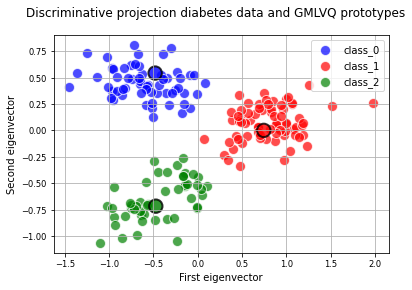

In [7]:
# Transform the data (scaled by square root of eigenvalues "scale = True")
transformed_data = model.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

# Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
transformed_model = model.transform(model.prototypes_, scale=True)

x_m = transformed_model[:, 0]
y_m = transformed_model[:, 1]

# Plot
fig, ax = plt.subplots()
fig.suptitle("Discriminative projection diabetes data and GMLVQ prototypes")
colors = ["blue", "red", "green"]
for i, cls in enumerate(model.classes_):
    ii = cls == labels
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=wine.target_names[model.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)

The transformed data and prototypes can be used to visualize the problem in a lower dimension,
which is also the space the model would compute the distance. The axis are the directions which
are the most discriminating directions (combinations of features). Hence, inspecting the
eigenvalues and eigenvectors (axis) themselves can be interesting.



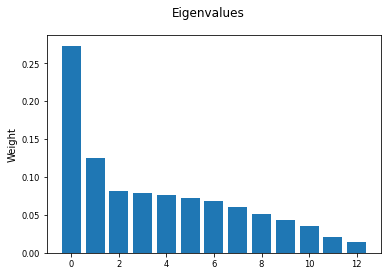

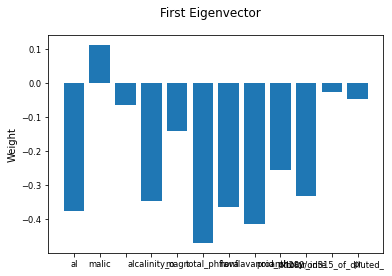

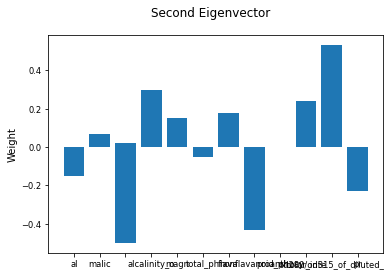

In [8]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model.eigenvalues_)), model.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)

# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 0])
ax.set_ylabel("Weight")
ax.grid(False)

fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model.omega_hat_[:, 1])
ax.set_ylabel("Weight")
ax.grid(False)

In the plots from the eigenvalues and eigenvector we see a similar effects as we could see from
just the diagonal of `lambda_`. The two leading (most relevant or discriminating) eigenvectors
mostly use the petal length and petal width in their calculation. The diagonal of the
relevance matrix can therefor be considered as a summary of the relevances of the features.



## References
_`[1]` Schneider, P., Biehl, M., & Hammer, B. (2009). "Adaptive Relevance Matrices in Learning
Vector Quantization" Neural Computation, 21(12), 3532–3561, 2009.

